# **SER Tecnicas de Hiperparametrizacion II**


</br>

Luisa Sanchez Avivar
    _luisasanavi@gmail.com_

In [1]:
# IMPORT LIBRARIES

# Processing
import librosa
import librosa.display
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython.display as ipd

# Files
import os
import joblib
import pickle

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils, to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
import tensorflow as tf

# ####### TEST ####### 
# Scipy
from scipy import signal
from scipy.io import wavfile

In [2]:
AUDIO_DATA_PATH = 'data/'
GPATH = '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/'
LPATH_DATA = 'SpeechEmotionRecognition/data/procesed/' 
SAMPLE_FILE = "03-01-01-01-01-01-01.wav"

# Maps
EMOTION_MAP = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
INTENSITY_MAP = {1:'normal', 2:'strong'}

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
dir_list = os.listdir(GPATH + AUDIO_DATA_PATH)
dir_list.sort()

print(dir_list)

emotion = []
gender = []
intensity = []
path = []

# Extraemos de cada archivo de sonido sus datos
for dir in dir_list:
  path_dir = os.listdir(GPATH + AUDIO_DATA_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filepath in path_dir:
    info_vector = filepath.split('.')[0].split('-')
    n_emotion = int(info_vector[2])
    n_gender = int(info_vector[6])
    n_intensity = int(info_vector[3])
    str_path = GPATH + AUDIO_DATA_PATH + dir + '/' + str(filepath)
    path.append(str_path)
    emotion.append(n_emotion)
    intensity.append(n_intensity)
    if n_gender%2 == 0:
      gender.append('female')
    else:
      gender.append('male')

# Construimos el data frame
EnglishSpeech_df = pd.DataFrame(columns=['emotion', 'gender', 'intensity', 'path'])
EnglishSpeech_df['emotion'] = emotion
EnglishSpeech_df['gender'] = gender
EnglishSpeech_df['intensity'] = intensity
EnglishSpeech_df['path'] = path
EnglishSpeech_df['emotion'] = EnglishSpeech_df['emotion'].map(EMOTION_MAP) 
EnglishSpeech_df['intensity'] = EnglishSpeech_df['intensity'].map(INTENSITY_MAP)


print("Size of the dataset: {} \n".format(len(EnglishSpeech_df)))
class_distribution = EnglishSpeech_df['emotion'].value_counts()
print(class_distribution)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24', 'RAVDESS']
Size of the dataset: 1440 

surprise    192
disgust     192
sad         192
calm        192
angry       192
happy       192
fear        192
neutral      96
Name: emotion, dtype: int64


### **OPERACIONES CON TECNICAS DE _DATA AUGMENTATION_**

In [21]:
def white_noise(data):
  '''
  Agrega ruido blanco a una pista de audio
  '''
  wn_spectrum = np.random.randn(len(data))
  data_wn = data + 0.005*wn_spectrum
  return data_wn

def shift_audio_sample(data, f_low = -5, f_high = 5, spec = 1):
  '''
  Desplaza una se;al acustica en un rango de frecuencia
  '''
  d_range = int(np.random.uniform(low=f_low, high = f_high)*spec) 
  data_shiftted = np.roll(data, d_range)

  return data_shiftted

def pitch_shift(data, bins_per_octave=12, pitch_pm = 2):
  '''
  Modula el tono y modifica la velocidad de una pista de audio
  '''
  pitch_change =  pitch_pm * 2*(np.random.uniform())   
  data_pitch = librosa.effects.pitch_shift(data.astype('float64'),16000, n_steps=pitch_change, bins_per_octave=bins_per_octave)
  return data_pitch


### **OPERACIONES CON CARACTERISTICAS**

In [19]:
def get_features(df, modifier):
  '''
  Extrae las caracteristicas de un conjunto de pistas de audio a 
  partir de un dataframe usando librosa

  Aguments
  ---------
    df : dataframe
    Dataframe que contiene el path donde se encuentra la pista de audio
    modifier: Function
    Funcion que modifica los datos

  Return
  -------
   data: np.array 
   Caracteristicas extraidas

  '''
  bar_data_range = tqdm(range(len(df)))
  data = pd.DataFrame(columns = ['data'])
  for index in bar_data_range:
    data_features = modifier(df.path[index])
    data.loc[index] = [data_features]

  return data

def get_features_single_file(pathfile):
  '''
  Extrae las caracteristicas  de una unica pista de audio usando MFCC 
  a traves de librosa.
  
  Aguments
  ---------
    pathfile: str 
      Path del archivo del que se extraeran las caracteristicas

  Return
  -------
    data_features

  '''
  X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
  mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
  data_features = np.mean(mfcc.T, axis = 0)

  return data_features



def get_features_white_noise(pathfile):
  '''
  Extrae las caracteristicas  de una unica pista de audio usando MFCC 
  a traves de librosa habiendoles aplicado ruido blanco.
  
  Aguments
  ---------
    pathfile: str 
      Path del archivo del que se extraeran las caracteristicas

  Return
  -------
    data_features

  '''
  X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
  # X = librosa.core.load(random_sample)[0]

  x_data_wn = white_noise(X)
  mfcc = librosa.feature.mfcc(y=x_data_wn, sr=sample_rate, n_mfcc=40)
  data_features = np.mean(mfcc.T, axis = 0)

  return data_features


def get_features_shiftted(pathfile):
  '''
  Extrae las caracteristicas  de una unica pista de audio usando MFCC 
  a traves de librosa habiendo desplazado las frecuencias perviamente.
  
  Aguments
  ---------
    pathfile: str 
      Path del archivo del que se extraeran las caracteristicas

  Return
  -------
    data_features

   '''
  X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
  # X = librosa.core.load(random_sample)[0]

  x_data_wn = shift_audio_sample(X)
  mfcc = librosa.feature.mfcc(y=x_data_wn, sr=sample_rate, n_mfcc=40)
  data_features = np.mean(mfcc.T, axis = 0)

  return data_features


def get_features_pitch(pathfile):
  '''
  Aplica modulacion del tono en cada muestra y despues extrae las caracteristicas 
  usando el algoritmo MFCC
  
  Aguments
  ---------
    pathfile: str 
      Path del archivo del que se extraeran las caracteristicas

  Return
  -------
    data_features

  '''
  X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
  # X = librosa.core.load(random_sample)[0]

  x_data_wn = pitch_shift(X)
  mfcc = librosa.feature.mfcc(y=x_data_wn, sr=sample_rate, n_mfcc=40)
  data_features = np.mean(mfcc.T, axis = 0)


  return data_features

In [28]:
def concat_features(*features):
  '''
  Concatena varios arrays de caracteristicas devolviendo la combinacion de todos ellos

  '''
  features_list = []
  for feature in features:
    # Cada valor es una caracteristica
    feature_df = pd.DataFrame(feature['data'].values.tolist())
    # Concateno las columnas genero y emocion para poder dividirlo mas tarde
    feature_spec = pd.concat((feature_df, EnglishSpeech_df['gender'], EnglishSpeech_df['emotion']), axis = 1)
    # Elimino filas vacias
    feature_spec = feature_spec.fillna(0)
    # Añado a la lista
    features_list.append(feature_spec)
  
  features_complete_df = pd.concat(features_list, ignore_index = True)
  return shuffle(features_complete_df)


def read_features():
  '''
  Lee las independientemente las caracteristicas de cada set 
  '''
  # Leemos las caracteristicas estandar (sin data augmentation)
  features_standard = get_features(EnglishSpeech_df, get_features_single_file)
  try:
    pickle.dump(features_standard, open(GPATH + LPATH_DATA + 'features_standard_RAVDESS.pkl', 'wb'))
  except Exception as ex:
    print(ex)
  print("Standard features into file")
  # Leemos para Ruido Blanco
  features_wn = get_features(EnglishSpeech_df, get_features_white_noise)
  try:
    pickle.dump(features_wn, open(GPATH + LPATH_DATA + 'features_wn_RAVDESS.pkl', 'wb'))
  except Exception as ex:
    print(ex)
  print("White Noise features into file")

  # Leemos para Desplazamiento del Sonido
  features_shiftted = get_features(EnglishSpeech_df, get_features_shiftted)
  try:
    pickle.dump(features_shiftted, open(GPATH + LPATH_DATA + 'features_shiftted_RAVDESS.pkl', 'wb'))
  except Exception as ex:
    print(ex)
  print("Shiftted into file")

  # Leemos para Modificacion del Tono
  features_pitch = get_features(EnglishSpeech_df, get_features_pitch)
  try:
    pickle.dump(features_pitch, open(GPATH + LPATH_DATA + 'features_pitch_RAVDESS.pkl', 'wb'))
  except Exception as ex:
    print(ex)
  print("Pitch Tunning features into file")

  return features_standard, features_wn, features_shiftted, features_pitch
  

### **MODELOS y ENTRENAMIENTO**

In [15]:
def model_CNN(x_train, n_classes):
  model = Sequential()

  model.add(Conv1D(128, 5,padding='same',
                  input_shape=(x_train.shape[1],1),
                   activity_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=(8)))
  model.add(Conv1D(128, 5,padding='same',activity_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(Flatten())
  # Numero de clases
  model.add(Dense(n_classes))
  model.add(Activation('softmax'))

  return model

def plot_loss_acc(history):
  # Mostramos la grafica loss 
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('Loss')
  ax1.set(xlabel='epoch', ylabel='loss')
  ax1.legend(['train', 'test'], loc='upper right')

  # Mostramos la grafica accuracy
  ax2.plot(history.history['accuracy'])
  ax2.plot(history.history['val_accuracy'])
  ax2.set_title('Validation')
  ax2.set(xlabel='epoch', ylabel='acc')

  ax2.legend(['train', 'test'], loc='lower right')

In [31]:
def split_training_test(df, n_splits_=1, test_size_=0.33, train_size_=None):
  '''
  Divide el dataset en entrenamieto y test utilizando StratifiedShuffleSplit
  Aguments
  ---------
  Return
  -------
  '''
  X = df.drop(['gender', 'emotion'], axis=1)
  Y = df.emotion
  test_train_stratified = StratifiedShuffleSplit(n_splits = n_splits_, test_size = test_size_, random_state=12)
  for train_index, test_index in test_train_stratified.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

  return X_train, X_test, Y_train, Y_test


def data_normalization(val_train, val_test):
  '''
  Normaliza los datos mejorando la precision y la velocidad del proceso de entrenamiento
  Aguments
  ---------
  Return
  -------
  '''
  mean = np.mean(val_train, axis=0)
  std = np.std(val_train, axis=0)

  X_train = (val_train - mean)/std
  X_test = (val_test - mean)/std

  return X_train, X_test


def data_to_categorical(x_train_norm, y_train, x_test_norm, y_test):
  '''
  Categoriza los datos y los formatea para su uso con keras. Asume que x_train y x_test estan normalizados.
  Aguments
  ---------
  Return
  -------
  '''
  # Preparamos los datos para la categorizacion
  x_train_norm = np.array(x_train_norm)
  y_train = np.array(y_train)
  x_test_norm = np.array(x_test_norm)
  y_test = np.array(y_test)

  # One hot encode 
  label_encoder = LabelEncoder()
  y_train = np_utils.to_categorical(label_encoder.fit_transform(y_train))
  y_test = np_utils.to_categorical(label_encoder.fit_transform(y_test))


  return x_train_norm, y_train, x_test_norm, y_test, label_encoder


def dataset_splitted_gender(dataframe, gender):
  '''
  Devuelve el dataset divido en entrenamiento y test segun el genero

  '''
  if gender == 'female':
    female_features_df = dataframe[(dataframe['gender'] == 'female')]
    X_train, X_test, Y_train, Y_test = data_process(female_features_df)

  elif gender == 'male':
    male_features_df = dataframe[(dataframe['gender'] == 'male')]
    X_train, X_test, Y_train, Y_test = data_process(male_features_df)

  elif gender == '':
    X_train, X_test, Y_train, Y_test = data_process(dataframe)

  return X_train, X_test, Y_train, Y_test




def data_process(features_df):
  '''
  Devuelve el conjunto de datos divido en entrenamiento test procesado correctamente

  '''
  # Division entre entrenamiento y test
  _X_train, _X_test, _Y_train, _Y_test =split_training_test(features_df) 

  # 2. Normaliza los datos
  x_train_norm, x_test_norm = data_normalization(_X_train, _X_test)
  # print(x_train_female_norm.shape)

  # 3. Categorización
  _X_train, Y_train, _X_test, Y_test, labels = data_to_categorical(x_train_norm, _Y_train, x_test_norm, _Y_test)
  # print(labels_female.classes_)

  # 4. Cambio de Dimensión
  X_train = np.expand_dims(_X_train, axis=2)
  X_test = np.expand_dims(_X_test, axis=2)

  return X_train, X_test, Y_train, Y_test

In [22]:
features_standard_, features_wn_, features_shiftted_, features_pitch_ = read_features()




  0%|          | 0/1440 [00:00<?, ?it/s]


  0%|          | 2/1440 [00:00<01:47, 13.38it/s]


  0%|          | 3/1440 [00:00<02:00, 11.95it/s]


  0%|          | 4/1440 [00:00<02:09, 11.11it/s]


  0%|          | 5/1440 [00:00<02:13, 10.71it/s]


  0%|          | 7/1440 [00:00<02:13, 10.76it/s]


  1%|          | 9/1440 [00:00<02:13, 10.72it/s]


  1%|          | 10/1440 [00:00<02:19, 10.22it/s]


  1%|          | 11/1440 [00:01<02:22, 10.02it/s]


  1%|          | 12/1440 [00:01<02:27,  9.69it/s]


  1%|          | 13/1440 [00:01<02:32,  9.36it/s]


  1%|          | 14/1440 [00:01<02:33,  9.30it/s]


  1%|          | 15/1440 [00:01<02:31,  9.41it/s]


  1%|          | 16/1440 [00:01<02:29,  9.51it/s]


  1%|          | 17/1440 [00:01<02:29,  9.53it/s]


  1%|▏         | 18/1440 [00:01<02:32,  9.34it/s]


  1%|▏         | 19/1440 [00:01<02:35,  9.14it/s]


  1%|▏         | 20/1440 [00:02<02:32,  9.32it/s]


  2%|▏         | 22/1440 [00:02<02:24,  9.83it/s]


  2%|▏         | 23/1440

[Errno 2] No such file or directory: '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/SpeechEmotionRecognition/data/procesed/features_standard_RAVDESS.pkl'
Standard features into file





  0%|          | 2/1440 [00:00<03:17,  7.28it/s]


  0%|          | 3/1440 [00:00<03:03,  7.81it/s]


  0%|          | 4/1440 [00:00<02:58,  8.03it/s]


  0%|          | 5/1440 [00:00<02:48,  8.49it/s]


  0%|          | 6/1440 [00:00<02:45,  8.69it/s]


  0%|          | 7/1440 [00:00<02:46,  8.62it/s]


  1%|          | 8/1440 [00:00<02:43,  8.77it/s]


  1%|          | 9/1440 [00:01<02:50,  8.39it/s]


  1%|          | 10/1440 [00:01<02:49,  8.42it/s]


  1%|          | 11/1440 [00:01<02:47,  8.53it/s]


  1%|          | 12/1440 [00:01<02:51,  8.33it/s]


  1%|          | 13/1440 [00:01<02:52,  8.25it/s]


  1%|          | 14/1440 [00:01<02:53,  8.21it/s]


  1%|          | 15/1440 [00:01<02:51,  8.30it/s]


  1%|          | 16/1440 [00:01<02:53,  8.22it/s]


  1%|          | 17/1440 [00:02<02:52,  8.23it/s]


  1%|▏         | 18/1440 [00:02<02:53,  8.17it/s]


  1%|▏         | 19/1440 [00:02<02:52,  8.22it/s]


  1%|▏         | 20/1440 [00:02<02:53,  8.19it/s]


  1%|▏         | 

[Errno 2] No such file or directory: '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/SpeechEmotionRecognition/data/procesed/features_wn_RAVDESS.pkl'
White Noise features into file





  0%|          | 2/1440 [00:00<02:46,  8.65it/s]


  0%|          | 4/1440 [00:00<02:34,  9.26it/s]


  0%|          | 6/1440 [00:00<02:26,  9.81it/s]


  0%|          | 7/1440 [00:00<02:31,  9.49it/s]


  1%|          | 9/1440 [00:00<02:28,  9.66it/s]


  1%|          | 10/1440 [00:01<02:37,  9.11it/s]


  1%|          | 11/1440 [00:01<02:41,  8.87it/s]


  1%|          | 12/1440 [00:01<02:47,  8.51it/s]


  1%|          | 13/1440 [00:01<02:45,  8.63it/s]


  1%|          | 14/1440 [00:01<02:41,  8.85it/s]


  1%|          | 15/1440 [00:01<02:41,  8.80it/s]


  1%|          | 16/1440 [00:01<02:51,  8.31it/s]


  1%|          | 17/1440 [00:01<02:49,  8.40it/s]


  1%|▏         | 18/1440 [00:02<02:54,  8.15it/s]


  1%|▏         | 19/1440 [00:02<02:55,  8.08it/s]


  1%|▏         | 20/1440 [00:02<02:51,  8.27it/s]


  1%|▏         | 21/1440 [00:02<02:46,  8.53it/s]


  2%|▏         | 22/1440 [00:02<02:42,  8.75it/s]


  2%|▏         | 23/1440 [00:02<02:43,  8.68it/s]


  2%|▏        

[Errno 2] No such file or directory: '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/SpeechEmotionRecognition/data/procesed/features_shiftted_RAVDESS.pkl'
Shiftted into file





  0%|          | 1/1440 [00:01<35:39,  1.49s/it]


  0%|          | 2/1440 [00:01<26:53,  1.12s/it]


  0%|          | 3/1440 [00:01<20:24,  1.17it/s]


  0%|          | 4/1440 [00:02<16:00,  1.49it/s]


  0%|          | 5/1440 [00:02<12:58,  1.84it/s]


  0%|          | 6/1440 [00:02<10:42,  2.23it/s]


  0%|          | 7/1440 [00:02<09:18,  2.56it/s]


  1%|          | 8/1440 [00:03<08:10,  2.92it/s]


  1%|          | 9/1440 [00:03<07:36,  3.13it/s]


  1%|          | 10/1440 [00:03<07:10,  3.32it/s]


  1%|          | 11/1440 [00:03<06:50,  3.48it/s]


  1%|          | 12/1440 [00:04<06:51,  3.47it/s]


  1%|          | 13/1440 [00:04<06:30,  3.66it/s]


  1%|          | 14/1440 [00:04<06:21,  3.73it/s]


  1%|          | 15/1440 [00:05<06:17,  3.78it/s]


  1%|          | 16/1440 [00:05<06:12,  3.82it/s]


  1%|          | 17/1440 [00:05<06:13,  3.81it/s]


  1%|▏         | 18/1440 [00:05<06:23,  3.70it/s]


  1%|▏         | 19/1440 [00:06<06:32,  3.62it/s]


  1%|▏         | 2

[Errno 2] No such file or directory: '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/SpeechEmotionRecognition/data/procesed/features_pitch_RAVDESS.pkl'
Pitch Tunning features into file


In [29]:
feat_complete_df = concat_features(features_standard_, features_wn_)

In [32]:
X_train_wn, X_test_wn, y_train_wn, y_test_wn = dataset_splitted_gender(feat_complete_df, '')

In [55]:
print("Entrenamiento con {} caracteristicas".format(feat_complete_df.shape[0]))
model = model_CNN(X_train_wn, y_train_wn.shape[1])
model.summary()

Entrenamiento con 2880 caracteristicas
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_12 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_13 (Activation)   (None, 5, 128)            0         
_________________________________________________________________
dropout_9 (Drop

In [56]:
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt, 
              metrics=['accuracy'])


# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

history = model.fit(X_train_wn, y_train_wn, 
                        batch_size=16, 
                        epochs=1000, 
                        validation_data=(X_test_wn, y_test_wn),
                        callbacks=[rlrp, es])

Epoch 1/1000
121/121 [==============================] - 2s 10ms/step - loss: 3.0550 - accuracy: 0.1587 - val_loss: 2.7297 - val_accuracy: 0.2156
Epoch 2/1000
121/121 [==============================] - 1s 9ms/step - loss: 2.7432 - accuracy: 0.2142 - val_loss: 2.5840 - val_accuracy: 0.2355
Epoch 3/1000
121/121 [==============================] - 1s 9ms/step - loss: 2.5850 - accuracy: 0.2422 - val_loss: 2.4733 - val_accuracy: 0.2271
Epoch 4/1000
121/121 [==============================] - 1s 9ms/step - loss: 2.4746 - accuracy: 0.2374 - val_loss: 2.3880 - val_accuracy: 0.2492
Epoch 5/1000
121/121 [==============================] - 1s 9ms/step - loss: 2.3721 - accuracy: 0.2305 - val_loss: 2.3208 - val_accuracy: 0.2461
Epoch 6/1000
121/121 [==============================] - 1s 9ms/step - loss: 2.3225 - accuracy: 0.2495 - val_loss: 2.2676 - val_accuracy: 0.2229
Epoch 7/1000
121/121 [==============================] - 1s 8ms/step - loss: 2.2548 - accuracy: 0.2462 - val_loss: 2.2272 - val_accuracy

8/8 [==============================] - 0s 8ms/step - loss: 1.8314 - accuracy: 0.3607
Loss: 1.8313935995101929 
Accuracy: 36.06729805469513%


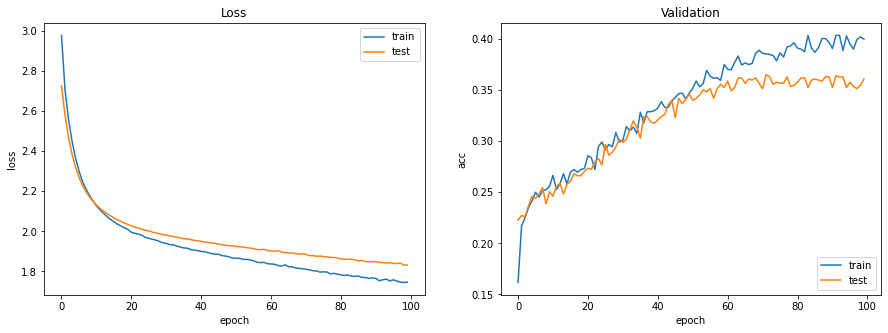

In [51]:
plot_loss_acc(history)
# Evaluamos contra test
score = model.evaluate(X_test_wn, y_test_wn, batch_size=128)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

8/8 [==============================] - 0s 7ms/step - loss: 1.8326 - accuracy: 0.3649
Loss: 1.8325821161270142 
Accuracy: 36.48790717124939%


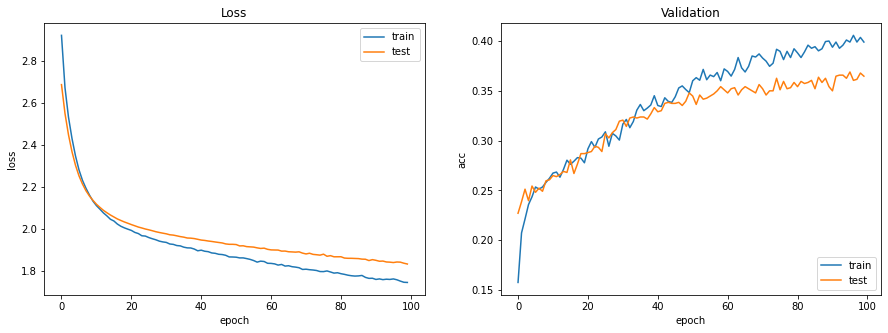

In [54]:
plot_loss_acc(history)
# Evaluamos contra test
score = model.evaluate(X_test_wn, y_test_wn, batch_size=128)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

8/8 [==============================] - 0s 6ms/step - loss: 1.7499 - accuracy: 0.3849
Loss: 1.7499182224273682 
Accuracy: 38.485804200172424%


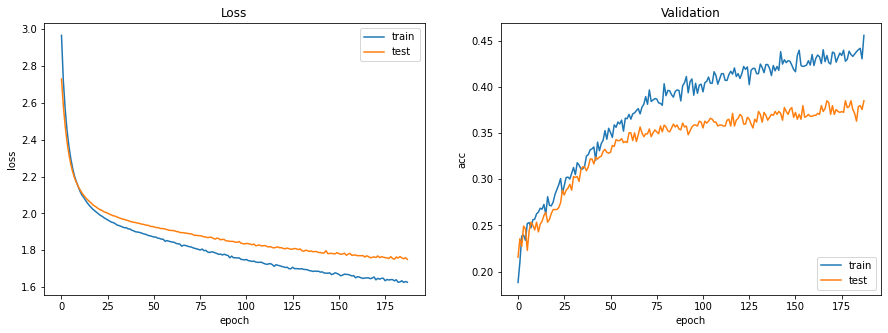

In [57]:
plot_loss_acc(history)
# Evaluamos contra test
score = model.evaluate(X_test_wn, y_test_wn, batch_size=128)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))